# Bollinger Band Trading Strategy Analysis


Jericho Calago

In [87]:
#Imports here
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## 1. Introduction

The aim of this report is to analyze the performance of the Bollinger Band trading indicator. A Bollinger Band is a technical analysis metric that relies on simple moving averages (SMAs) to provide insight on both price volatility and price trends.

A Bollinger Band consists of 3 main components, the middle band (which is equal to the simple moving average or SMA), the upper band (2 standard deviations above the SMA), and the lower band (2 standard deviations below the SMA).

Traders use Bollinger Bands to analyze volatility levels of a given commodity. For example, the width of a bollinger band (distance between the upper and lower band), is a visualization of volatility levels in a given commodity price. 

Additionally, Bollinger Bands can be used as one of many indicators to try and predict price trends. If a commodity's price is close to the upper or lower band (but not exceeeding it), this might be an indicator of an upward or downward price trend repectively. However, if the price does exceed the upper or lower band, this may be an indicator of overbuying/selling, which could be an indicator of trend reversion (the end of a upward or downward trend respectively).

We will be analyzing the effectiveness of using Bollinger Bands calculated on a 20 day moving average, and their ability to accurately predict market trends on a 20 day period. Traders may seek a full understanding of how Bollinger Bands interact with market prices, as it might yield a possible short-term profit making strategy by buying and selling Bitcoin according to Bollinger Band indicators.

With this dataset, we are looking to answer the question "how does the effectiveness of the Bollinger Band indicators vary with different levels of price volatility." 

More specifically, how does the relationship between Bollinger Band predicted PNL (predicted profit) and realized PNL (amount of actual profit) over a 20 day period change for different levels of price volatility within our dataset?

## 2. Dataset Discussion

The dataset was downloaded from the following link: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data.

According to the documentation, the data was grabbed from multiple global exchanges of Bitcoin, utilizing their APIs (online http addresses that allow for programmatic data extraction)

In [88]:
df = pd.read_csv("bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv")
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
df.shape[0]

4857377

Since Bollinger Band indicators only relies on the price levels (and not the total quantity or value of items being traded), we can safely disregard these columns in our dataset, and only look at the columns that have to do with time (Timestamp), and price, which are:
- Open: Price at the start of the trading period
- High: Highest observed price during the trading period
- Low: Lowest observed price during the trading period
- Close: Price at the end of the trading period

In [90]:
df = df[["Timestamp", "Open", "High", "Low", "Close"]]
df.head()

,Timestamp,Open,High,Low,Close
0,1325317920,4.39,4.39,4.39,4.39
1,1325317980,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN


In [91]:
timestamp1 = 1325317920
timestamp2 = 1325317980

dt1 = datetime.datetime.fromtimestamp(timestamp1)
dt2 = datetime.datetime.fromtimestamp(timestamp2)

print(dt1)
print(dt2)

2011-12-31 01:52:00
2011-12-31 01:53:00


As we can see above, by taking the first two timestamps from our dataset, we can see that each row is an increment of 1 minute from the previous one. To create Bollinger Bands on a 20 day period, we must first aggregate the cleaned data into a table that has at least two columns: Price at a given Day, and the Day, and then calculate the Bollinger Band limits along with predictions and realized profits and losses (abbreviated PNL). 

We will not be disregarding any numerical outlier data within our analysis, as outlier events must be accounted for in order to consistently make money on the market. By failing to account for market crashes or large upticks, we (and the traders who might use this analysis) lose the ability to prepare for these high volatility events where profit and loss margins are at their highest. We only will disregard rows/days where we lack a sufficient amount of data, as this may potentially misrepresent the underlying data trends within a trading day.

Specifically, the 3 variables we will create are as follows:
- Bollinger Band Predicted PNL (the amount of profit adjusted by bitcoin price the Bollinger Band method predicts in the next 20 days)
- Realied PNL (the amount of profit/loss adjusted by bitcoin price that actually ocurred in the next 20 days)
- Bollinger Band Width (Volatility, or a numerical representation of how much the price is changing within a certain trading period)

## 3. Dataset Cleaning

We can start by dropping the NaN values that are clearly visible when we print df.head().

In [92]:
nan_filter = df.dropna().copy()
print(f"Before: {df.shape[0]}, After: {nan_filter.shape[0]}")

Before: 4857377, After: 3613769


From here, we need to get rid of the days where there aren't enough points of data to construct a reliable daily average for the price. We can construct a column in the dataframe that uses python's datetime methods to convert the timestamp into the date, then get rid of the dates that have less than 10 hours of trading data (less than 600 1-minute intervals).

Leaving these dates out might leave gaps in our dataset, which might make the Bollinger Band indicators less accurate as it has less data to work with, however leaving them in might **also** make the indicators less accurate, as we may have regions where not enough data exists to provide a full picture of the market, and we may be misrepresenting the data by leaving these dates in. Instead of testing both possibilities, we will simply remove these dates.

In [93]:
# create the Date column
nan_filter["Date"] = nan_filter["Timestamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).date())
nan_filter.head()

,Timestamp,Open,High,Low,Close,Date
0,1325317920,4.39,4.39,4.39,4.39,2011-12-31
478,1325346600,4.39,4.39,4.39,4.39,2011-12-31
547,1325350740,4.50,4.57,4.50,4.57,2011-12-31
548,1325350800,4.58,4.58,4.58,4.58,2011-12-31
1224,1325391360,4.58,4.58,4.58,4.58,2011-12-31


In [94]:
# Filter out days with less than 10 hours of trading data (less than 600 instances)
date_counts = nan_filter["Date"].value_counts()
day_count_greater_600 = date_counts[date_counts > 600].index

day_filter = nan_filter[nan_filter["Date"].isin(day_count_greater_600)]
print(day_filter.head())
print(f"Before: {nan_filter.shape[0]}, After: {day_filter.shape[0]}")

         Timestamp   Open   High    Low  Close        Date
620531  1362549780  44.25  44.25  44.24  44.24  2013-03-06
620532  1362549840  44.25  44.25  44.25  44.25  2013-03-06
620533  1362549900  44.36  44.36  44.36  44.36  2013-03-06
620535  1362550020  44.58  44.59  44.58  44.59  2013-03-06
620536  1362550080  44.59  44.59  44.59  44.59  2013-03-06
Before: 3613769, After: 3554801


From here, we need to get rid of the rows whose date is too isolated to be part of a 20-day moving average, and label the ones that are as "Calculable" or not.

For example, if we measure time from t = 0 to infinity, and have datapoints for t = 1, 5, 6 and t = 20, 21, 22, ..., 39. 
- Mark t = 39 as "Calculable" (as we can construct a 20-day moving average for t = 39)
- Mark t = 20, 21, ..., 38 as "not Calculable" (as we must keep them to calculate the 20-day moving average at t = 39, but can't calculate their own 20-day moving average)
- Drop t = 1, 5, and 6 (as they aren't part of any day's 20-day moving average).



In [95]:
# given a date object, generate a list of the 19 days before it
def generate_19_days_before(date):
    days_before = []
    for i in range(1, 20):
        day_i_before = date - datetime.timedelta(days = i)
        days_before.append(day_i_before)
    return days_before

# grab a list of all the remaining days in our dataset
all_days = day_filter["Date"].unique()

# Set to store all calculable days
days_with_calculable_sma = set()
# Set to store all days we must keep
relevant_days = set()

# Find all days where 20 day MSA is calculable
for date in all_days:
    day_range = generate_19_days_before(date)
    is_calculable = True

    for past_day in day_range:
        if past_day not in all_days:
            is_calculable = False
            break
    if is_calculable:
        days_with_calculable_sma.add(date)
        relevant_days.update(day_range)

connected_day_filter = day_filter[day_filter["Date"].isin(relevant_days) | day_filter["Date"].isin(days_with_calculable_sma)]
print(connected_day_filter.head())
print(f"Before: {len(all_days)}, After: {len(relevant_days)}")

         Timestamp    Open    High     Low   Close        Date
666550  1365310920  142.79  142.79  142.79  142.79  2013-04-07
666559  1365311460  142.79  142.79  142.79  142.79  2013-04-07
666560  1365311520  142.79  142.79  142.79  142.79  2013-04-07
666587  1365313140  142.17  142.17  142.17  142.17  2013-04-07
666590  1365313320  142.17  142.17  142.17  142.17  2013-04-07
Before: 2901, After: 2824


Before we do any further operations, let's agreggate the data so that we have one row for every day, rather than every minute. We can take the mean of the Open, High, Low, and Close for all of the datapoints at a given day to preserve these price values.

In [96]:
grouped_day_df = connected_day_filter.groupby("Date").mean().reset_index()[["Date", "Open", "High", "Low", "Close"]]
grouped_day_df.head()

,Date,Open,High,Low,Close
0,2013-04-07,157.013678,157.115734,156.925182,157.031821
1,2013-04-08,185.637813,185.821793,185.434712,185.664840
2,2013-04-09,216.701803,216.871010,216.497538,216.733490
3,2013-04-10,196.401490,197.200384,195.179733,196.201922
4,2013-04-11,107.131973,107.804018,106.197963,106.997931


Now we can create the "Is_Calculable" column based on the definition we defined above:

In [97]:
# Function to determine whether a date is calculable or not
def determine_is_calculable(date):
    if date in days_with_calculable_sma:
        return True
    if date in relevant_days:
        return False
    # if we get down here, that means a date in our dataset doesn't have calculatable SMA 
    # and also isn't used in any other day's SMA, so we should print an error message to recognize this
    print("You should never get here...")
    return False

# Code to create the "Calculable" category
grouped_day_df.loc[:, "Is_Calculable"] = grouped_day_df.loc[:, "Date"].apply(determine_is_calculable)
print(grouped_day_df.head())
print(grouped_day_df["Is_Calculable"].value_counts())

         Date        Open        High         Low       Close  Is_Calculable
0  2013-04-07  157.013678  157.115734  156.925182  157.031821          False
1  2013-04-08  185.637813  185.821793  185.434712  185.664840          False
2  2013-04-09  216.701803  216.871010  216.497538  216.733490          False
3  2013-04-10  196.401490  197.200384  195.179733  196.201922          False
4  2013-04-11  107.131973  107.804018  106.197963  106.997931          False
Is_Calculable
True     2608
False     228
Name: count, dtype: int64


Lastly, we can create a column for the OHLC (open-high-low-close) average. By averaging the open, high, low, and close over a given trading period (in our case, over a day), we can combine all of these metrics into one number to represent the "price" at a given day.

In [98]:
def calculate_ohlc_avg(row):
    return (row["Open"] + row["High"] + row["Low"] + row["Close"]) / 4
# apply "calculate_ohlc_avg" to all of the rows (axis = 1) on our grouped day dataset
grouped_day_df["Ohlc_Avg"] = grouped_day_df.apply(calculate_ohlc_avg, axis=1)

final_filtered_df = grouped_day_df[["Date", "Ohlc_Avg", "Is_Calculable"]].copy()
final_filtered_df.head()

,Date,Ohlc_Avg,Is_Calculable
0,2013-04-07,157.021604,False
1,2013-04-08,185.639790,False
2,2013-04-09,216.700960,False
3,2013-04-10,196.245882,False
4,2013-04-11,107.032971,False


Now that we are finished cleaning the dataset, we can move on to constructing the Bollinger Bands and analyzing their performance.

## 4. <u>Research Question</u>: How does the Relationship between `x` and `y` Change based on Different Values of `z` in the Dataset?

With this dataset, we are looking to answer the question "how does the effectiveness of Bollinger Band indicators vary with different levels of price volatility." More specifically, how do Bollinger Band indicators (predicting trend swings when the commodity price exceeds the bounds of the Bollinger Band) vary in accuracy and performance given different levels of price volatility (a metric we will define as the distance between the top and bottom of the bollinger bands).

Let's start by constructing 4 columns to represent our Bollinger Band. "20_Day_MSA" will be the middle band, "Band_Top" will be our upper band "Band_Bot" will be our lower band, and "Band_Width" will be the distance from the top to the bottom of the band.

Additionally, we will create the column "20_Day_Prev", which calculates adjusted profit over the previous 20 days. We will use this column later on in our analysis.

In [99]:
final_filtered_df.loc[:, '20_Day_MSA'] = final_filtered_df.loc[:, 'Ohlc_Avg'].rolling(window=20).mean()
final_filtered_df.loc[:, '20_Day_SD'] = final_filtered_df.loc[:, 'Ohlc_Avg'].rolling(window=20).std()


def calculate_top_band(row):
    return row["20_Day_MSA"] + 2 * row["20_Day_SD"]

def calculate_bot_band(row):
    return row["20_Day_MSA"] - 2 * row["20_Day_SD"]

def calculate_band_width(row):
    return row["Band_Top"] - row["Band_Bot"]

def calculate_20_day_prev(row):
    curr_date = row["Date"]
    prev_date = curr_date - datetime.timedelta(days = 19)
    curr_price = row["Ohlc_Avg"]
    prev_date_df = final_filtered_df[final_filtered_df["Date"] == prev_date]

    row_exists = prev_date_df.shape[0] > 0
    if row_exists:
        prev_price = prev_date_df.iloc[0]["Ohlc_Avg"]
        return (curr_price - prev_price) / prev_price
    return None

final_filtered_df.loc[:, "Band_Top"] = final_filtered_df.apply(calculate_top_band, axis=1)
final_filtered_df.loc[:, "Band_Bot"] = final_filtered_df.apply(calculate_bot_band, axis=1)
final_filtered_df.loc[:, "Band_Width"] = final_filtered_df.apply(calculate_band_width, axis = 1)
final_filtered_df.loc[:, "20_Day_Prev"] = final_filtered_df.apply(calculate_20_day_prev, axis=1)
final_filtered_df.head()

,Date,Ohlc_Avg,Is_Calculable,20_Day_MSA,20_Day_SD,Band_Top,Band_Bot,Band_Width,20_Day_Prev
0,2013-04-07,157.021604,False,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-04-08,185.639790,False,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-04-09,216.700960,False,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-04-10,196.245882,False,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-04-11,107.032971,False,NaN,NaN,NaN,NaN,NaN,NaN


Since the 20 day moving average is calculated using pandas' ".rolling" function, until we get to row 20 in our dataset, we can't calculate the moving average, so it uses NaN as a placeholder. While it may seem like we could've just dropped all NaN values at this state instead of finding "Is_Calculable", we use Is_Calculable to find gaps within our dataset (see below):

In [100]:
final_filtered_df.iloc[1130:1135]

,Date,Ohlc_Avg,Is_Calculable,20_Day_MSA,20_Day_SD,Band_Top,Band_Bot,Band_Width,20_Day_Prev
1130,2016-07-14,659.355018,True,657.027702,16.103817,689.235335,624.820068,64.415266,-0.008388
1131,2016-07-15,664.303759,True,656.996283,16.088189,689.172660,624.819905,64.352754,0.049780
1132,2016-07-31,629.606749,False,656.836476,16.354818,689.546112,624.126840,65.419272,-0.048105
1133,2016-08-01,616.214778,False,655.508881,18.494714,692.498309,618.519453,73.978855,-0.067457
1134,2016-08-02,572.658128,False,651.958889,26.128013,704.214916,599.702863,104.512054,-0.131487


Note how the dates in August (8/1, 8/2), aren't calculable as we are missing the days before them (the entire end of July), however Pandas still calculated a 20 day moving average and standard deviation, as it simply calculating based on the previous 20 rows, regardless if they are the actual 20 consecutive days before the current one.

We can now get rid of all of the rows that aren't calculable along with the calculable column itself, then plot the Bollinger Bands using pyplot.

         Date    Ohlc_Avg  20_Day_MSA    Band_Top   Band_Bot  Band_Width  \
0  2013-04-26  134.727011  126.300454  206.001107  46.599801  159.401306   
1  2013-04-27  132.785210  125.088635  203.549909  46.627360  156.922548   
2  2013-04-28  134.424427  122.527866  195.842443  49.213290  146.629153   
3  2013-04-29  141.990713  118.792354  178.197349  59.387359  118.809989   
4  2013-04-30  140.246259  115.992373  164.261251  67.723495   96.537755   

   20_Day_Prev  
0    -0.141984  
1    -0.284716  
2    -0.379678  
3    -0.276465  
4     0.310309  


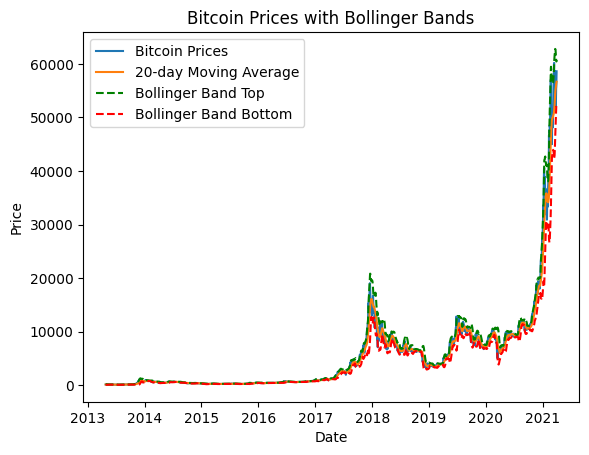

In [101]:
final_filtered_df = final_filtered_df[final_filtered_df["Is_Calculable"]]
bollinger_band_df = final_filtered_df.drop(columns=["Is_Calculable", "20_Day_SD"]).reset_index(drop=True)
print(bollinger_band_df.head())

def plot_bollinger_band(dataset, start = 0, end = -1):
    plt.clf()
    if end == -1:
        end = dataset.shape[0]
    
    dataset_subset = dataset.iloc[start:end]
    # Plot Bitcoin prices
    plt.plot(dataset_subset['Date'], dataset_subset['Ohlc_Avg'], label='Bitcoin Prices')

    # Plot 20-day Moving Average
    plt.plot(dataset_subset['Date'], dataset_subset['20_Day_MSA'], label='20-day Moving Average')

    # Plot Bollinger Bands
    plt.plot(dataset_subset['Date'], dataset_subset['Band_Top'], label='Bollinger Band Top', linestyle='--', color='green')
    plt.plot(dataset_subset['Date'], dataset_subset['Band_Bot'], label='Bollinger Band Bottom', linestyle='--', color='red')


    # Add labels and legend
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Bitcoin Prices with Bollinger Bands')
    plt.legend()

plot_bollinger_band(bollinger_band_df)




The dataset is still quite large even after all of the datacleaning. We can use the function we just defined to graph segments of our data on the dataframe indicies.

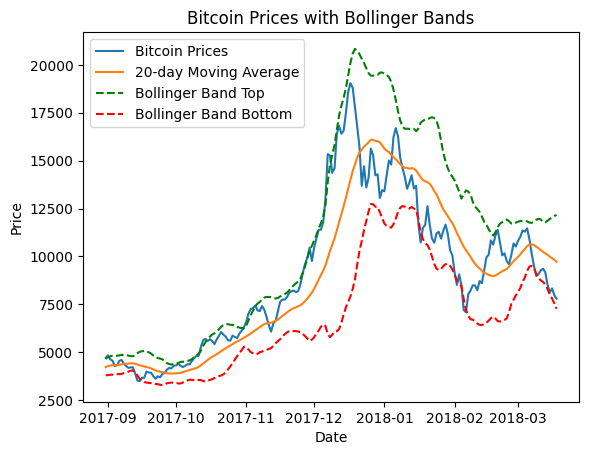

In [102]:
plot_bollinger_band(bollinger_band_df, 1300, 1500)

Just be looking at this subset data, we can see some instances where Bollinger Band indicators are accurate (the downard trend in January and February), and others where the indicators seem to fail (the large spike in November and early December seems to indicate a crash much earlier than what actually ocurred).

We will test Bollinger Band indicators by analyzing the profit generated if one was to buy 1 Bitcoin, hold for 20 days, then sell. Let's create a new column "20_Day_Profit", that represents this amount. Note that we must call "dropna()", as if the day 20 days into the future doesn't exist in our dataset, our function to calculate the 20 day pnl returns "None", and therefore the row should be dropped.

Additionally, we will adjust our profit to the price of bitcoin by dividing the net profit by the price of bitcoin, as the price jumping $200 in 20 days when bitcoin is worth $10,000 is a lot less of an extreme jump as bitcoin prices jumping 200 in 20 days when they start at $100.

In [103]:
def calculate_20_day_pnl(row):
    curr_date = row["Date"]
    future_date = curr_date + datetime.timedelta(days = 19)
    curr_price = row["Ohlc_Avg"]
    future_date_df = bollinger_band_df[bollinger_band_df["Date"] == future_date]

    row_exists = future_date_df.shape[0] > 0
    if row_exists:
        future_price = future_date_df.iloc[0]["Ohlc_Avg"]
        return (future_price - curr_price) / curr_price
    return None

bollinger_band_df["20_Day_Profit"] = bollinger_band_df.apply(calculate_20_day_pnl, axis = 1)
profit_df = bollinger_band_df.dropna().copy()
profit_df.head()

,Date,Ohlc_Avg,20_Day_MSA,Band_Top,Band_Bot,Band_Width,20_Day_Prev,20_Day_Profit
0,2013-04-26,134.727011,126.300454,206.001107,46.599801,159.401306,-0.141984,-0.179162
1,2013-04-27,132.785210,125.088635,203.549909,46.627360,156.922548,-0.284716,-0.158452
2,2013-04-28,134.424427,122.527866,195.842443,49.213290,146.629153,-0.379678,-0.139507
3,2013-04-29,141.990713,118.792354,178.197349,59.387359,118.809989,-0.276465,-0.170187
4,2013-04-30,140.246259,115.992373,164.261251,67.723495,96.537755,0.310309,-0.161352


Now that we have the predicted 20_day_profit, we can create a column that represents what the Bollinger Band predicts will happen in the next 20 days. We can create the column "Bollinger_Indicator" and create 3 possible conditions:
- down_swing: The market was trending upwards, but is now going to start trending downwards
- up_swing: The market was trending downwards, but is now going to start trending upwards
- sidways: The market will remain constant

We decide on this indicator for each day in our dataset, based on how close the Ohlc Average is to any of the edges of the band. If it exceeds the bottom or top band, we expect a swing in the opposite direction. However if it stays within the band, we expect the market to remain relatively consistent. The following code creates this column. 

In [104]:
def calculate_bollinger_prediction(row):
    dist_top = row["Band_Top"] - row["Ohlc_Avg"]
    if dist_top < 0: # if the ohlc_avg crosses above the top band
        return "down_swing"
    dist_bottom = row["Ohlc_Avg"] - row["Band_Bot"]
    if dist_bottom < 0: # if the ohlc_avg crosses below the bottom band
        return "up_swing"
    return "sideways"

profit_df.loc[:, "Bollinger_Indicator"] = profit_df.apply(calculate_bollinger_prediction, axis=1)
profit_df["Bollinger_Indicator"].value_counts()

Bollinger_Indicator
sideways      2086
down_swing     227
up_swing       109
Name: count, dtype: int64

We can also create a column to represent how the price actually changed. If the previous 20 days had positive growth while the next 20 days had negative growth, this would indicate the current day is part of a down_swing, and vice-versa for the up_swing. 

We must first define thresholds for what is considred a "up_swing", "down_swing", and "sideways". We can define the "distance" as the difference between the 20 day pnl in the future (20_Day_Profit) and the 20 day pnl from the past (20_Day_Prev). If the distance is negative, that means we are experience a large shift towards a downward trend, as the future profits were less than the previous profits. We can create a column for distance then use a boxplot to determine what levels of "distance" should be considered drastic enough to be considred a "swing".



<Axes: ylabel='Distance'>

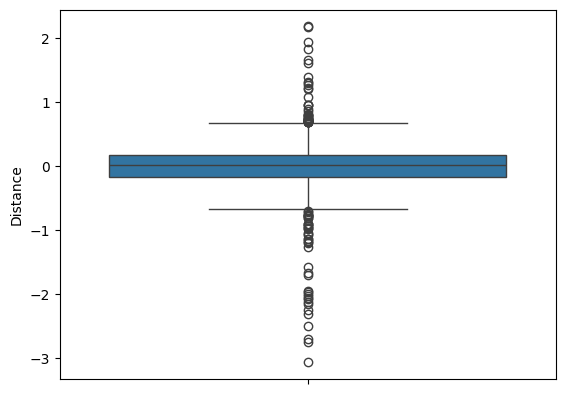

In [105]:
def calculate_difference(row):
    dist = row["20_Day_Profit"] - row["20_Day_Prev"]
    return dist
profit_df.loc[:, "Distance"] = profit_df.apply(calculate_difference, axis=1)
sns.boxplot(profit_df["Distance"])

As seen by the boxplot, outliers occurr when the distance is above ~0.55 or below ~ -0.65. Using these thresholds for up and down swings repsectively, the following code creates a new column: "Real_Condition" that indicates whether each row was part of an up_swing, down_swing, or if the market went sideways (held relatively constant).

In [106]:
def calculate_real_condition(row):
    if row["Distance"] < -0.65:
        return "down_swing"
    if row["Distance"] > 0.55:
        return "up_swing"
    return "sideways"
profit_df.loc[:, "Real_Condition"] = profit_df.apply(calculate_real_condition, axis=1)
profit_df.head()

profit_df["Real_Condition"].value_counts()

Real_Condition
sideways      2290
up_swing        87
down_swing      45
Name: count, dtype: int64

We can now analyze if there is a correlation between the Bollinger Band prediction and what actually happened (Real_Condition), using a bar plot.

Text(0.5, 1.0, 'Predicted vs Realized Price Swing Conditions')

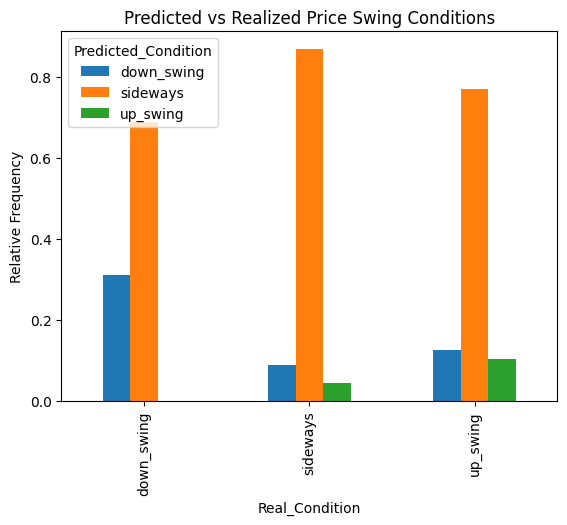

In [107]:
crosstab = pd.crosstab(profit_df["Real_Condition"], profit_df["Bollinger_Indicator"], normalize='index')
crosstab.plot.bar()
plt.legend(loc="upper left", title="Predicted_Condition")
plt.ylabel("Relative Frequency")
plt.title("Predicted vs Realized Price Swing Conditions")

To quantify how far the Bollinger Band prediction was from the actual price movement, we can define an additional column "Predicted_20_Day_PNL", which will be equal to the previous 20 day pnl plus a change factor determined by the Bollinger Band indicator. A simple example formula for the predicted PNL is as follows: 

The change factor is defined as the ratio between how far the actual price is from the ohlc average divided by 2 standard deviations, times the expected movement of the band extreme the ohlc average is closest to (0.55 for bottom band, 0.65 for top band) and sign adjusted for expected swings. For example:

- If the ohlc_average (current price) is 1.2 standard deviations ABOVE the 20 day moving average, we are still BELOW the top band, so we expect the upward trend to continue. We expect the PNL over the next 20 days to change by 1.2 * 0.65. 
- If the ohlc_average (current price) is 2.2 standard deviations ABOVE the 20 day moving average, we are now ABOVE the top band so we expect the upward trend to end (ie a down_swing). We expect the PNL over the next 20 days to change by -2.2 * 0.65.

In [108]:
TOP_BAND_RATE = 0.65
BOT_BAND_RATE = 0.55
def calculate_predicted_pnl(row):
    standard_deviation = row["Band_Width"] / 4
    prv_pnl = row["20_Day_Prev"]
    avg_dist = row["Ohlc_Avg"] - row["20_Day_MSA"]
    if avg_dist > 0: # if we are above the moving average
        if row["Ohlc_Avg"] < row["Band_Top"]: # if we are within the Bollinger Band
            return prv_pnl + avg_dist / (2 * standard_deviation) * TOP_BAND_RATE
        else:
            return prv_pnl - avg_dist / (2 * standard_deviation) * TOP_BAND_RATE
    else: # we are below (or at) the moving average
        if row["Ohlc_Avg"] > row["Band_Bot"]: # if we are within the Bollinger Band
            return prv_pnl + avg_dist / (2 * standard_deviation) * BOT_BAND_RATE
        else:
            return prv_pnl - avg_dist / (2 * standard_deviation) * BOT_BAND_RATE
profit_df.loc[:, "Bollinger_Prediction_PNL"] = profit_df.apply(calculate_predicted_pnl, axis=1)
profit_df.head()
profit_df.iloc[120:130]

,Date,Ohlc_Avg,20_Day_MSA,Band_Top,Band_Bot,Band_Width,20_Day_Prev,20_Day_Profit,Bollinger_Indicator,Distance,Real_Condition,Bollinger_Prediction_PNL
154,2014-01-27,785.499521,820.460563,865.010461,775.910665,89.099796,-0.040613,-0.167681,sideways,-0.127068,sideways,-0.472232
155,2014-01-28,785.350794,818.790540,866.033001,771.548078,94.484923,-0.041925,-0.201029,sideways,-0.159104,sideways,-0.431233
156,2014-01-29,795.458000,817.577566,865.952006,769.203127,96.748880,-0.048652,-0.196777,sideways,-0.148125,sideways,-0.300143
157,2014-01-30,793.045310,815.422954,864.154057,766.691851,97.462206,-0.103585,-0.208405,sideways,-0.104820,sideways,-0.356149
158,2014-01-31,802.925510,811.334956,847.766799,774.903112,72.863687,-0.056864,-0.219534,sideways,-0.162670,sideways,-0.183819
159,2014-02-01,815.188975,809.527621,840.829356,778.225886,62.603470,-0.001324,-0.286574,sideways,-0.285250,sideways,0.116238
160,2014-02-02,817.250533,809.576666,840.925917,778.227415,62.698503,-0.006006,-0.298386,sideways,-0.292380,sideways,0.153105
161,2014-02-03,807.810865,808.857792,839.643680,778.071904,61.571776,-0.038288,-0.266454,sideways,-0.228167,sideways,-0.056991
162,2014-02-04,804.453243,807.081890,834.188642,779.975138,54.213504,-0.025574,-0.237044,sideways,-0.211470,sideways,-0.078910
163,2014-02-05,797.047097,805.655921,831.645942,779.665900,51.980042,-0.002326,-0.315337,sideways,-0.313011,sideways,-0.184506


To create the categorical variable to quantify the volatility of bitcoin prices (in order to answer our research question), we can use the quartiles of the band_width as a categorical variable. Using .describe() to find the quartiles, we can create the function "generate_quartile_widths" which takes a row and outputs the quartile band-width it is in, then create a new column "Band_Width_Quartiles" to represent this variable.

In [109]:
print(profit_df["Band_Width"].describe())
def generate_quartile_widths(row):
    width = row["Band_Width"]
    if width < 116:
        return "1st"
    if width < 650:
        return "2nd"
    if width < 2101:
        return "3rd"
    return "4th"

profit_df.loc[:, "Band_Width_Quartiles"] = profit_df.apply(generate_quartile_widths, axis=1)
profit_df["Band_Width_Quartiles"].value_counts()
final_analysis_values = profit_df[["Date", "20_Day_Profit", "Bollinger_Prediction_PNL", "Band_Width_Quartiles"]]


count     2422.000000
mean      1733.349517
std       3154.342031
min         13.516319
25%        116.158145
50%        650.928620
75%       2101.237295
max      26293.678567
Name: Band_Width, dtype: float64


Now that we have our 3 variables (Bollinger Band's Prediction PNL, the realized 20 day PNL, and the quartiles of each of the different band widths), we can answer our question "how does the effectiveness of Bollinger Band indicators vary with different levels of price volatility" by plotting the predicted PNL and the realized PNL on a scatterplot, then differentiating the different band width quartiles (volatility levels) with 4 different hues. We plot the line y = x over our dataset to see where the Bollinger Band model over/underestimates the realized PNL.

Text(0.5, 1.0, 'Bollinger Band Predicted PNL vs Realized 20 Day PNL: Controlled By Volatility')

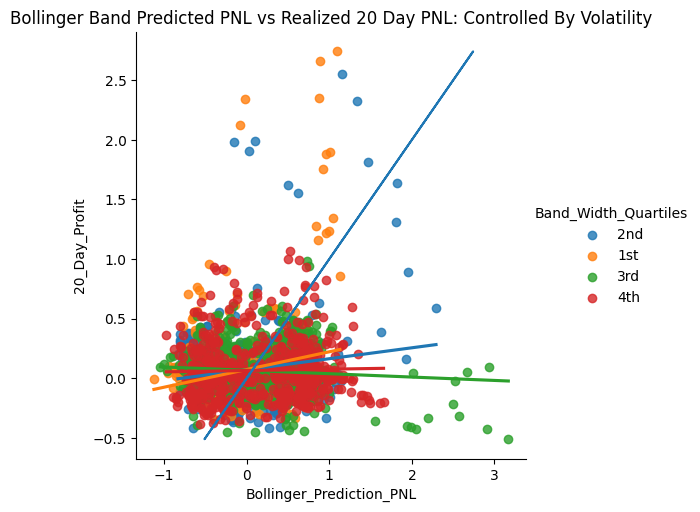

In [110]:
sns.lmplot(x='Bollinger_Prediction_PNL', y='20_Day_Profit', hue='Band_Width_Quartiles', ci=False, data=final_analysis_values)

plt.plot(final_analysis_values["20_Day_Profit"], final_analysis_values["20_Day_Profit"])
plt.title("Bollinger Band Predicted PNL vs Realized 20 Day PNL: Controlled By Volatility")

## 5. Conclusion

There are two main conclusions that we can gain from the analysis of Bollinger Bands on Bitcoin prices. The first is that there seems to be some correlation between Bollinger Bands and price swings. As seen by the barplot titled "Predicted vs Realized Price Swing Conditions", the prediction of the Bollinger Band had an effect on the relative frequencies of the 3 types of price swing conditions. For example, if Bollinger Bands predicted a sideways market, a sideways market was realized more often than if Bollinger Bands predicted an up_swing or down_swing, and this was true for the other two conditions as well. This implies that for its primary purpose (predicting trend reversions/swings), Bollinger Bands might be a useful indicator to consider.

The second conclusion results from the analysis of using Bollinger Bands to predict future Bitcoin Prices. While Bollinger Bands seem to be able to predict price swings with some consistency, the same can't be said for predicting future prices in general.

While some of the outliers accurately predicted the 20 day PNL, a vast majority of the predicted PNL values were far very far away from the Bollinger Prediction, with an even amount of over and under estimation. It is also worth noting that the 1st and 2nd quartiles had outliers where the Bollinger Prediction was closest to the Realized PNL, while the 3rd quartile had outliers that were the furthest from the Realized PNL (a consistent overestimation). The 4th quartile had the least amount of outliers.

The slopes for all volatility levels were much closer to 0 than the expected slope of 1, however all of them were distinct. The 1st quartile of volatilities had the steepest slope, followed by 2nd, 4th, than 3rd, which implies that the Bollinger Band method works best with lower amounts of volatilities.

This is similar to the shapes of the different volatiliy levels, the 3rd quartile of volatility has a shape that is very flat, while the 4th quartile is a cluster centered around (0,0). The 1st and 2nd quartiles have linear spreading outliers, but also cluster around (0, 0).

It is clear that Bollinger Bands (using the formula derived in this analysis) are not sufficient to use as the only tool to predict future prices, and should be used in tandem with other technical indicators that are better suited to predict prices. 

One general caveat of the above analysis is that the formula for Bollinger Band price prediction was somewhat arbitrary. It may be possible to edit the thresholds or potentially revamp the formula to result in better price prediction performance. Additionally, this analysis only takes into account Bitcoin prices. Different commodities (such as other cryptocurrencies or even other equities such as stocks), may react differently to changes in the market, and might not be as suited to Bollinger Band analysis, which may impact how useful this analysis is depending on the types of commodities a trader is looking to work with.

Analyzing other equities (such as stocks) using Bollinger Bands, or tweaking the price prediction formula to try and yield more consistent prediction accuracy would be possible follow up projects to this analysis.